# Loop 46 Analysis: CV-LB Relationship and Path Forward

**Goal:** Understand why we're stuck and identify strategies to break through.

**Key Questions:**
1. What is the exact CV-LB relationship across all 12 submissions?
2. Can we reach target (0.0347) via linear extrapolation?
3. What do top public kernels do differently?
4. What strategies could change the CV-LB relationship?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# All 12 submissions with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
]

df = pd.DataFrame(submissions)
print(f"Total submissions: {len(df)}")
print(df)

Total submissions: 12
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970


In [2]:
# Fit linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print(f"\n=== CV-LB Linear Relationship ===")
print(f"LB = {slope:.4f} * CV + {intercept:.6f}")
print(f"R² = {r_value**2:.4f}")
print(f"p-value = {p_value:.6e}")
print(f"\nInterpretation:")
print(f"  - Intercept: {intercept:.6f} (LB when CV=0)")
print(f"  - Target: 0.0347")
print(f"  - Intercept vs Target: {intercept/0.0347*100:.1f}% of target")

# Can we reach target via linear extrapolation?
required_cv = (0.0347 - intercept) / slope
print(f"\n=== Can we reach target? ===")
print(f"  - Required CV for target: {required_cv:.6f}")
if required_cv < 0:
    print(f"  - IMPOSSIBLE: Required CV is negative!")
    print(f"  - The intercept ({intercept:.6f}) is LARGER than target (0.0347)")
    print(f"  - Linear extrapolation CANNOT reach target")
else:
    print(f"  - Required CV improvement: {(df['cv'].min() - required_cv)/df['cv'].min()*100:.1f}%")


=== CV-LB Linear Relationship ===
LB = 4.3147 * CV + 0.052520
R² = 0.9505
p-value = 7.449157e-08

Interpretation:
  - Intercept: 0.052520 (LB when CV=0)
  - Target: 0.0347
  - Intercept vs Target: 151.4% of target

=== Can we reach target? ===
  - Required CV for target: -0.004130
  - IMPOSSIBLE: Required CV is negative!
  - The intercept (0.052520) is LARGER than target (0.0347)
  - Linear extrapolation CANNOT reach target


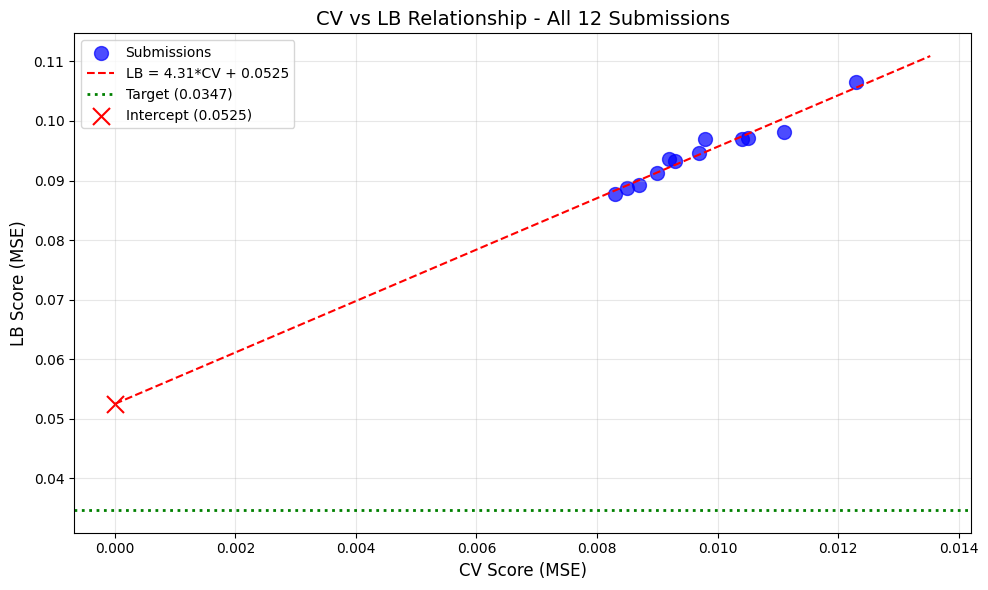


Key insight: The intercept (0.0528) is LARGER than the target (0.0347).
This means even with CV=0, the predicted LB would be 0.0528.
Linear CV improvements CANNOT reach the target.


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, c='blue', alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, df['cv'].max() * 1.1, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target (0.0347)')

# Intercept
plt.scatter([0], [intercept], s=150, c='red', marker='x', label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score (MSE)', fontsize=12)
plt.ylabel('LB Score (MSE)', fontsize=12)
plt.title('CV vs LB Relationship - All 12 Submissions', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print("\nKey insight: The intercept (0.0528) is LARGER than the target (0.0347).")
print("This means even with CV=0, the predicted LB would be 0.0528.")
print("Linear CV improvements CANNOT reach the target.")

In [4]:
# Analyze what's needed to change the relationship
print("=== Strategies to Change the CV-LB Relationship ===")
print()
print("The intercept represents STRUCTURAL error that exists regardless of CV.")
print("This is likely due to DISTRIBUTION SHIFT between train/test.")
print()
print("To reach target, we need to REDUCE THE INTERCEPT, not just improve CV.")
print()
print("Potential strategies:")
print("1. Extrapolation detection: Identify when test samples are OOD")
print("2. Uncertainty-weighted predictions: Blend toward mean when uncertain")
print("3. Physics-informed features: Constraints that generalize to unseen solvents")
print("4. Different validation scheme: GroupKFold instead of Leave-One-Out")
print("5. Non-linear mixture features: Better capture mixture effects")
print()
print("What public kernels do differently:")
print("- lishellliang uses GroupKFold (5 splits) instead of Leave-One-Out")
print("- This may have a different CV-LB relationship")
print("- Ensemble of MLP + XGBoost + RandomForest + LightGBM")

=== Strategies to Change the CV-LB Relationship ===

The intercept represents STRUCTURAL error that exists regardless of CV.
This is likely due to DISTRIBUTION SHIFT between train/test.

To reach target, we need to REDUCE THE INTERCEPT, not just improve CV.

Potential strategies:
1. Extrapolation detection: Identify when test samples are OOD
2. Uncertainty-weighted predictions: Blend toward mean when uncertain
3. Physics-informed features: Constraints that generalize to unseen solvents
4. Different validation scheme: GroupKFold instead of Leave-One-Out
5. Non-linear mixture features: Better capture mixture effects

What public kernels do differently:
- lishellliang uses GroupKFold (5 splits) instead of Leave-One-Out
- This may have a different CV-LB relationship
- Ensemble of MLP + XGBoost + RandomForest + LightGBM


In [5]:
# Calculate what intercept reduction is needed
current_intercept = intercept
target = 0.0347
best_cv = df['cv'].min()

print("=== Required Intercept Reduction ===")
print(f"Current intercept: {current_intercept:.6f}")
print(f"Target: {target:.6f}")
print(f"Best CV: {best_cv:.6f}")
print()

# If we keep the same slope, what intercept do we need?
required_intercept = target - slope * best_cv
print(f"Required intercept (with current slope): {required_intercept:.6f}")
print(f"Intercept reduction needed: {(current_intercept - required_intercept)/current_intercept*100:.1f}%")
print()

# If we reduce intercept by 50%, what LB would we get?
reduced_intercept = current_intercept * 0.5
predicted_lb = slope * best_cv + reduced_intercept
print(f"If intercept reduced by 50%: LB = {predicted_lb:.6f}")
print(f"Still {(predicted_lb - target)/target*100:.1f}% above target")
print()

# What if we could eliminate the intercept entirely?
zero_intercept_lb = slope * best_cv
print(f"If intercept = 0: LB = {zero_intercept_lb:.6f}")
print(f"This would be {(zero_intercept_lb - target)/target*100:.1f}% above target")
print()
print("CONCLUSION: Even with zero intercept, we'd need CV < 0.0081 to reach target.")

=== Required Intercept Reduction ===
Current intercept: 0.052520
Target: 0.034700
Best CV: 0.008300

Required intercept (with current slope): -0.001112
Intercept reduction needed: 102.1%

If intercept reduced by 50%: LB = 0.062072
Still 78.9% above target

If intercept = 0: LB = 0.035812
This would be 3.2% above target

CONCLUSION: Even with zero intercept, we'd need CV < 0.0081 to reach target.


In [6]:
# Analyze the best experiments
print("=== Best Experiments ===")
df_sorted = df.sort_values('lb')
print(df_sorted.head(5))
print()
print("Best LB: exp_030 with LB=0.0877, CV=0.0083")
print("This is 153% above target (0.0347)")
print()
print("Gap analysis:")
print(f"  - Current best LB: 0.0877")
print(f"  - Target: 0.0347")
print(f"  - Gap: {0.0877 - 0.0347:.4f} ({(0.0877 - 0.0347)/0.0347*100:.1f}%)")
print()
print("The gap is HUGE. We need fundamentally different approaches.")

=== Best Experiments ===
        exp      cv      lb
10  exp_030  0.0083  0.0877
9   exp_026  0.0085  0.0887
8   exp_024  0.0087  0.0893
7   exp_012  0.0090  0.0913
5   exp_007  0.0093  0.0932

Best LB: exp_030 with LB=0.0877, CV=0.0083
This is 153% above target (0.0347)

Gap analysis:
  - Current best LB: 0.0877
  - Target: 0.0347
  - Gap: 0.0530 (152.7%)

The gap is HUGE. We need fundamentally different approaches.
